In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
from emrecharge.colocation import (
    find_closest_locations,
    find_locations_in_distance,
    compute_fraction_for_aem_layer,
    generate_water_level_map,
    compute_colocations
)

from emrecharge.datasets import (
    EMDataset
)

from emrecharge.viz import (
    set_mesh_1d,
    plot_layer_model
)


In [3]:
gdf_aem_lines = gpd.read_file("../data/shp/alluvial_fan/lines_cdwr_sacv.geojson")

In [4]:
gdf_cv = gpd.read_file("../data/shp/cv.shp")
gdf_cv_3310 = gdf_cv.to_crs(3310)

In [5]:
from shapely import wkt

In [6]:
gdf_aem_lines_3310 = gdf_aem_lines.to_crs(3310)
gdf_aem_lines_3310 = gdf_aem_lines_3310.clip(gdf_cv_3310)

In [7]:
df_bwq = pd.read_csv('../data/water_quality/brackishwaterqualitylocation.csv')
df_bwq['geometry'] = df_bwq['geometry'].apply(wkt.loads)
gdf_bwq = gpd.GeoDataFrame(df_bwq, crs='epsg:4326')

In [8]:
df_fwq = pd.read_csv('../data/water_quality/freshwaterqualitylocation.csv')
df_fwq['geometry'] = df_fwq['geometry'].apply(wkt.loads)
gdf_fwq = gpd.GeoDataFrame(df_fwq, crs='epsg:4326')

In [9]:
gdf_bwq_cv = gdf_bwq.clip(gdf_cv)
gdf_fwq_cv = gdf_fwq.clip(gdf_cv)

In [10]:
gdf_fwq_cv.shape

(1135, 13)

In [11]:
gdf_fwq_cv.to_file("../data/water_quality/freshwaterqualitylocation.geojson")
gdf_bwq_cv.to_file("../data/water_quality/brackishwaterqualitylocation.geojson")


In [12]:
gdf_bwq_cv.shape

(70, 13)

<Axes: >

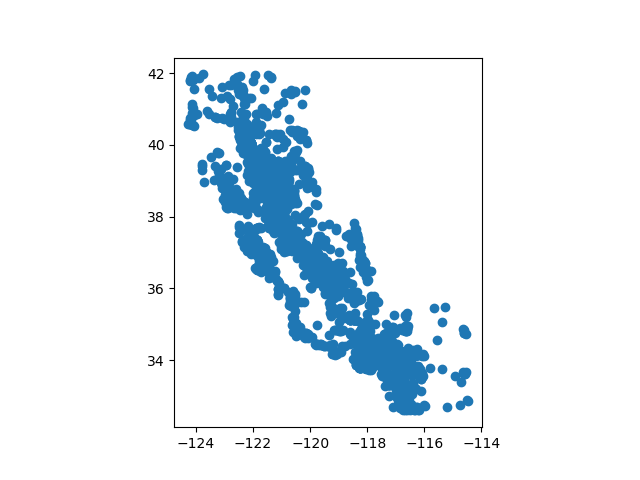

In [13]:
gdf_fwq.plot()

In [14]:
gdf_plss = gpd.read_file("plss.geojson")
gdf_plss_3310 = gdf_plss.to_crs(3310)

## Load groundwater subbasin boundaries and reduce to CV

In [15]:
gdf_basins = gpd.read_file("basins.geojson")
gdf_basins_3310 = gdf_basins.to_crs(3310)

In [16]:
out = gdf_basins_3310.intersects(gdf_cv_3310.geometry[0])

In [17]:
gdf_basins_3310_cv = gdf_basins_3310.loc[out]

In [18]:
gdf_basins_3310_cv['area_square_km'] = gdf_basins_3310_cv.area.values/1e6

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
gdf_basins_3310_cv.to_file("./subbasins_cv_all.geojson")

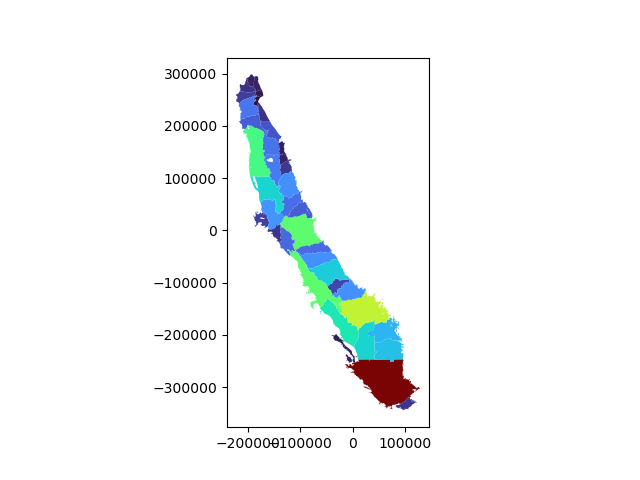

In [23]:
out = gdf_basins_3310_cv.plot(column='area_square_km', cmap='turbo')

In [24]:
gdf_basins_3310_cv.shape

(41, 5)

In [25]:
df_sediment_type = pd.read_csv("sediment_type.csv")

In [26]:
xy_sed = df_sediment_type[['UTMX', 'UTMY']].values

In [27]:
xy_sed.shape

(36488, 2)

In [28]:
SPATIAL_UNIT = 'm'
em_data = EMDataset(
    "./em_resistivity.csv", 
    "./thickness.csv",
    SPATIAL_UNIT
)

In [29]:
inds_aem_active = np.load("inds_active_aem.npy")

In [30]:
xy_aem = em_data.xy

In [31]:
xy_aem_active = xy_aem[inds_aem_active,:]

In [32]:
for d in [10, 600]:
    locs, inds = find_locations_in_distance(xy_aem, xy_sed, distance=d)
    print (f"{d:d}, # of co-located sed. profiles: {locs.shape[0]:d}")

10, # of co-located sed. profiles: 46
600, # of co-located sed. profiles: 11645


In [33]:
pd.DataFrame(data=locs, columns=['UTMX', 'UTMY']).to_csv("colocated_sed_locations_600m.csv", index=False)

In [34]:
xy_sed.shape

(36488, 2)

In [35]:
inds

array([    1,     3,     4, ..., 36485, 36486, 36487])

In [36]:
xy_sed.shape

(36488, 2)

In [37]:
locs.shape

(11645, 2)

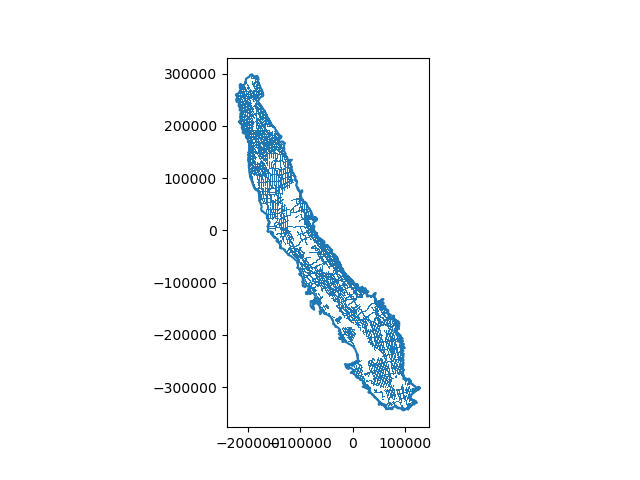

In [38]:
fig, ax = plt.subplots(1,1)
ax.plot(xy_aem_active[:,0], xy_aem_active[:,1], ',')
gdf_cv_3310.boundary.plot(ax=ax)
# ax.plot(locs[:,0], locs[:,1], '.', ms=1)
ax.set_aspect(1)

## Preprocess sediment type data

In [39]:
df_sediment_type = pd.read_csv("sediment_type.csv")
spatial_conversion = 1.
df_sediment_type[['UTMX', 'UTMY']] = df_sediment_type[['UTMX', 'UTMY']] * spatial_conversion
group = df_sediment_type.groupby('WELL_ID')
drop_key = []
for key in list(group.groups.keys()):
    if group.get_group(key).shape[0]!=1:
        drop_key.append(key)
df_sediment_type = df_sediment_type.set_index('WELL_ID')
df_sediment_type = df_sediment_type.drop(index=drop_key)

sediment_to_cf = {'fine':0, 'coarse':1, 'unknown':np.nan, 'unrecognized':np.nan, 'soil':0, 'rock':np.nan}
well_ids = df_sediment_type.index.to_list()
top_list = []
bottom_list = []
sediment_type_list = []
well_id_list = []
is_lith_hq_list = []
for well_id in well_ids:
    measure = df_sediment_type.loc[well_id]['MEASUREMENTS']
    tmp_dict = json.loads(measure)
    meta_data = df_sediment_type.loc[well_id]['METADATA']
    meta_dict = json.loads(meta_data)        
    thickness = tmp_dict['THICKNESS']
    top_list.append(np.r_[0, np.cumsum(thickness[:-1])]*spatial_conversion)
    bottom_list.append(np.r_[np.cumsum(thickness)]*spatial_conversion)
    n_layer = len(thickness)
    sediment_type_list.append(tmp_dict['SEDIMENT_TYPE'])
    well_id_list.append([well_id] * n_layer)
    is_lith_hq_list.append([meta_dict['IS_LITH_HQ']] * n_layer)
top_list = np.hstack(top_list)
bottom_list = np.hstack(bottom_list)
sediment_type_list = np.hstack(sediment_type_list)
well_id_list = np.hstack(well_id_list)
is_lith_hq_list = np.hstack(is_lith_hq_list)
coarse_fraction = [sediment_to_cf[sed] for sed in sediment_type_list]
df_sediment_type_interval = pd.DataFrame()
df_sediment_type_interval.insert(0, "top_meter", top_list, True)
df_sediment_type_interval.insert(0, "bottom_meter", bottom_list, True)
df_sediment_type_interval.insert(0, "WELL_ID", well_id_list, True)
df_sediment_type_interval.insert(0, "coarse_fraction", coarse_fraction, True)
df_sediment_type_interval.insert(0, "IS_LITH_HQ", is_lith_hq_list, True)
# Make sure we only use the HQ data from CDWR. 
df_sediment_type_interval = df_sediment_type_interval.loc[df_sediment_type_interval['IS_LITH_HQ']==1.]
well_ids_unique = df_sediment_type_interval['WELL_ID'].unique()
df_sediment_type = df_sediment_type.loc[well_ids_unique]

In [40]:
xy_sed = df_sediment_type[['UTMX', 'UTMY']].values

In [41]:
from shapely import Point

In [42]:
geometry = [Point(xy_sed[ii, 0], xy_sed[ii, 1]) for ii in range(xy_sed.shape[0])]

In [43]:
gdf_sed_pts = gpd.GeoDataFrame({}, geometry=geometry, crs=3310)

In [44]:
counts = []
for ii in range(len(gdf_basins_3310_cv)):
    counts.append(gdf_basins_3310_cv.geometry[gdf_basins_3310_cv.index[ii]].contains(gdf_sed_pts).values.sum())

In [45]:
counts = np.array(counts)

In [46]:
density = counts / gdf_basins_3310_cv.area_square_km.values

In [47]:
gdf_basins_3310_cv['counts'] = counts
gdf_basins_3310_cv['sed_density'] = density

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
n_sed = xy_sed.shape[0]

In [49]:
np.sort(gdf_basins_3310_cv['sed_density'].values)

array([0.        , 0.        , 0.        , 0.06433731, 0.06596062,
       0.19382228, 0.25148167, 0.28332304, 0.29388578, 0.29855824,
       0.32397161, 0.32749971, 0.36110373, 0.36299338, 0.36529518,
       0.3701904 , 0.37025975, 0.37529608, 0.41744181, 0.42533863,
       0.43457993, 0.45117225, 0.46599578, 0.48946364, 0.54801506,
       0.55326868, 0.56211073, 0.58762946, 0.60267096, 0.63299795,
       0.66143204, 0.66370483, 0.74273178, 0.75546996, 0.75735123,
       0.88017107, 0.90088873, 1.11492705, 1.15150102, 1.5435843 ,
       1.70255508])

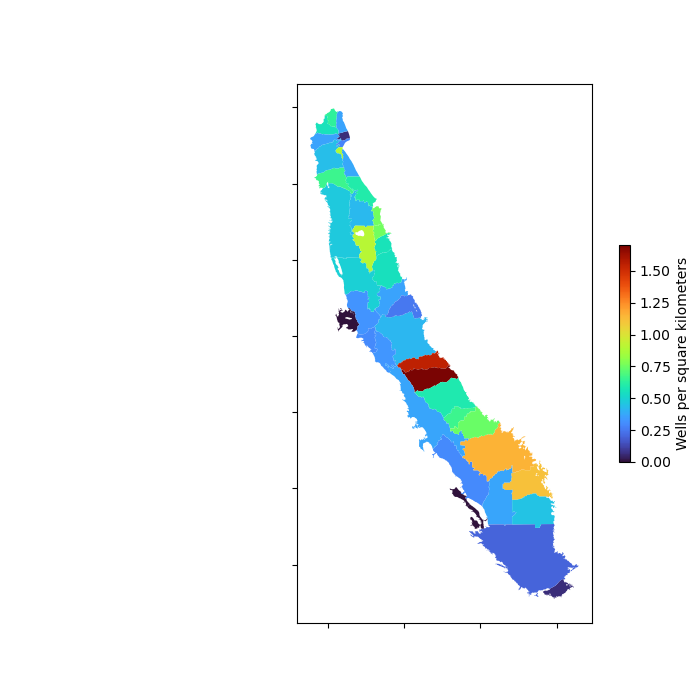

In [50]:
fig, ax = plt.subplots(1,1, figsize=(7, 7))
out = gdf_basins_3310_cv.plot(column='sed_density', cmap='turbo', ax=ax, legend=True, legend_kwds={'label': "Wells per square kilometers", 'fraction':0.02})
# out = gdf_basins_3310_cv.plot(column='counts', cmap='turbo', ax=ax, legend=True, legend_kwds={'label': "Wells counts", 'fraction':0.02})
# ax.plot(xy_sed[:,0], xy_sed[:,1], 'k,')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

## Load EM resistivity data

In [51]:
SPATIAL_UNIT = 'm'
em_data = EMDataset(
    "./em_resistivity.csv", 
    "./thickness.csv",
    SPATIAL_UNIT
)

## Preprocess water level data

In [52]:
# Note: year and season will be variable that we are going to get from the data base. 
df_thickness = pd.read_csv("./thickness.csv")
data_type = df_thickness['KIND'].values[0]
year = df_thickness['YEAR'].values[0]
season = df_thickness['SEASON'].values[0].capitalize()
    
if data_type == 'aem':
    dx=1600 * spatial_conversion
    dy=1600 * spatial_conversion
    max_distance= 4000 * spatial_conversion
elif data_type == 'ttem':
    dx=10 * spatial_conversion
    dy=10 * spatial_conversion
    max_distance=50 * spatial_conversion

In [53]:
df_waterlevel = pd.read_csv("./waterlevel.csv")
df_waterlevel = df_waterlevel.set_index('WELL_ID')
well_ids = df_waterlevel.index.to_list()
year_list = []
season_list = []
gsewse_list = []
well_id_list = []
if len(well_ids) != 0:
    for well_id in well_ids:
        measure = df_waterlevel.loc[well_id]['MEASUREMENTS']
        tmp_dict = json.loads(measure)
        year_list.append(tmp_dict['YEAR'])
        season_list.append(tmp_dict['SEASON'])
        gsewse_list.append(tmp_dict['GSE_WSE'])
        well_id_list.append(well_id * np.ones(len(tmp_dict['YEAR']), dtype=int))
    year_list = np.hstack(year_list)
    season_list = np.hstack(season_list)
    gsewse_list = np.hstack(gsewse_list)
    well_id_list = np.hstack(well_id_list)
    df_waterlevel_table = pd.DataFrame()
    df_waterlevel_table.insert(0, "YEAR", year_list, True)
    df_waterlevel_table.insert(0, "SEASON", season_list, True)
    df_waterlevel_table.insert(0, "GSE_WSE", gsewse_list, True)
    df_waterlevel_table.insert(0, "WELL_ID", well_id_list, True)
    df_waterlevel_survey = df_waterlevel_table[(df_waterlevel_table['YEAR']==year) & (df_waterlevel_table['SEASON']==season)]
    df_waterlevel_survey = df_waterlevel_survey.set_index('WELL_ID')
    df_waterlevel_survey[['UTMX', 'UTMY']] = df_waterlevel.loc[df_waterlevel_survey.index][['UTMX', 'UTMY']]
else:
    df_waterlevel_survey = pd.DataFrame({"YEAR":[], "SEASON":[], "GSE_WSE":[], "UTMX":[], "UTMY":[], "WELL_ID":[]})
    df_waterlevel_survey = df_waterlevel_survey.set_index('WELL_ID')
df_waterlevel_survey[['GSE_WSE','UTMX', 'UTMY']] = df_waterlevel_survey[['GSE_WSE','UTMX', 'UTMY']] * spatial_conversion
df_waterlevel_survey = df_waterlevel_survey[df_waterlevel_survey['GSE_WSE']>0.]

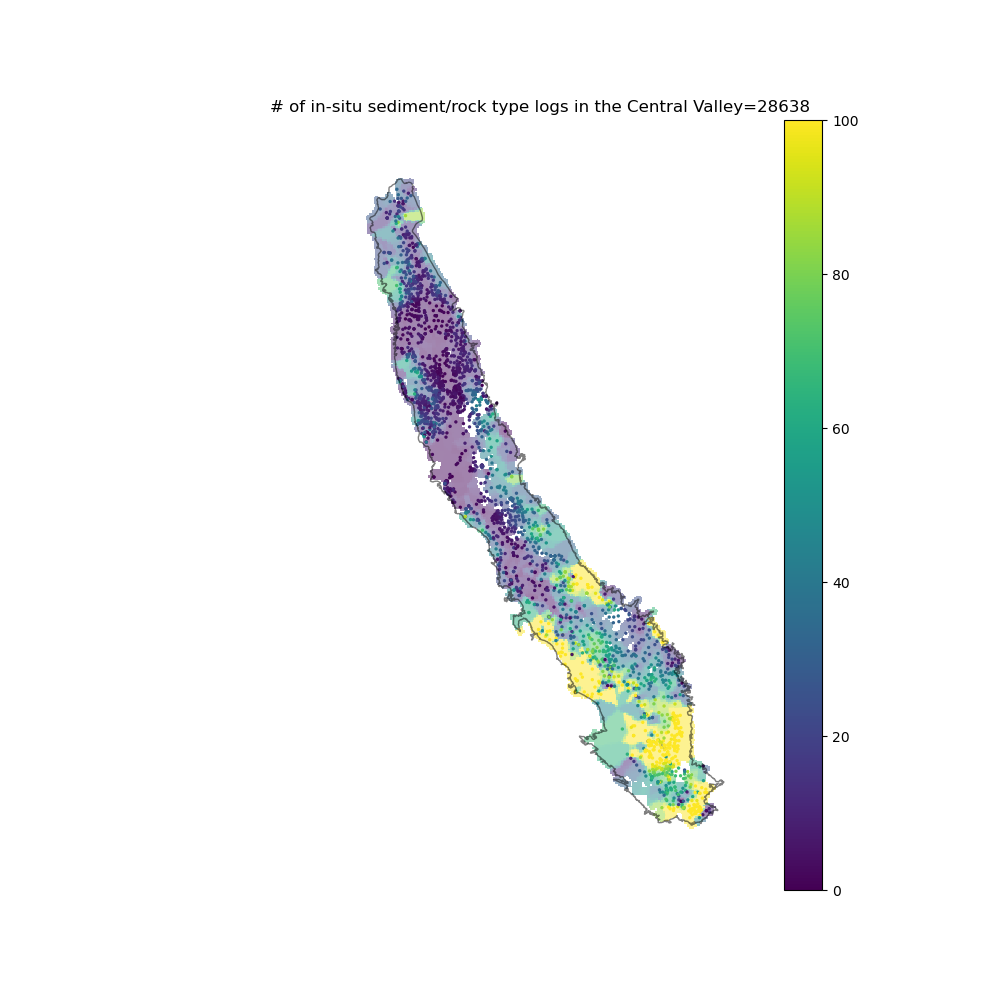

In [54]:
# if we end up using the constant water level this is used to show a status in the UI
k_nearest_points = 100
        
water_table = generate_water_level_map(
    df_waterlevel_survey, 
    em_data, 
    dx=dx,
    dy=dy,
    max_distance=max_distance,
    k_nearest_points=k_nearest_points,    
    water_level_contour_df=None
)  
x_wt = df_waterlevel_survey['UTMX'].values
y_wt = df_waterlevel_survey['UTMY'].values
xy_wt = np.c_[x_wt, y_wt]
gse_wse = df_waterlevel_survey['GSE_WSE'].values

fig, ax = plt.subplots(1,1, figsize=(10, 10))
# gdf_plss_3310.boundary.plot(ax=ax)
gdf_cv_3310.boundary.plot(ax=ax, color='k', linewidth=1, alpha=0.5)
ax.pcolormesh(water_table['x'], water_table['y'], water_table['wse_idw'], vmin=0, vmax=100, alpha=0.5)
out = ax.scatter(
    df_waterlevel_survey['UTMX'], df_waterlevel_survey['UTMY'], c=df_waterlevel_survey['GSE_WSE'],
    s=2, vmin=0, vmax=100
)

plt.colorbar(out, ax=ax)
ax.set_title(f"# of in-situ sediment/rock type logs in the Central Valley={n_sed}")
plt.axis('off')
plt.show()

In [55]:
df_waterlevel_survey.to_csv("wt_cv.csv", index=True)

In [56]:
from emrecharge.colocation import (
    find_closest_locations,
    find_locations_in_distance,
    compute_fraction_for_aem_layer,
)

def compute_colocations(
    distance_threshold: int, xy_aem: np.array, df_lithology: pd.DataFrame
):
    lithology_group = df_lithology.groupby("WELL_ID")
    df_lithology_collar = lithology_group[["UTMX", "UTMY"]].mean()
    xy_lithology = df_lithology_collar[["UTMX", "UTMY"]].values

    # find the well locations that are within the distance_threshold of any em suruvey location
    xy_lithology_colocated, inds_lithology_colocated = find_locations_in_distance(
        xy_aem, xy_lithology, distance=distance_threshold
    )

    # use each well location to lookup the cloest em survey location
    d_aem_colocated, inds_aem_colocated = find_closest_locations(
        xy_lithology_colocated, xy_aem
    )

    # get the subset of co-located survey locations
    xy_aem_colocated = xy_aem[inds_aem_colocated, :]

    # get the subset of co-located wells
    df_lithology_collar_colocated = df_lithology_collar.loc[
        df_lithology_collar.index[inds_lithology_colocated]
    ]

    # get names of the colocated wells
    well_names_colocated = df_lithology_collar_colocated.index.to_list()

    # there should always be the same number of co-ocated wells and survey locations
    assert inds_aem_colocated.size == inds_lithology_colocated.size

    n_colocated = inds_aem_colocated.size
    mean_separation_distance = d_aem_colocated.mean()
    return dict(
        n_colocated=n_colocated,
        mean_separation_distance=mean_separation_distance,
        xy_em=xy_aem_colocated,
        lithology_collar=df_lithology_collar_colocated,
        well_names=well_names_colocated,
        inds_em=inds_aem_colocated,
        inds_lithology=inds_lithology_colocated,
    )

In [57]:
from emrecharge.rockphysics import (
    from_sigma_to_fraction,
    compute_rho_to_cf_mappings_with_rho,
    rock_physics_transform_rk_2018
)
def compute_integral(df: pd.DataFrame, n_bootstrap=1000):
    def func(x):
        hz = x.bottom - x.top
        return 1.0 / ((1.0 / x.rho_aem * hz).sum() / hz.sum())

    def func_cf(x):
        hz = x.bottom - x.top
        return (x.f_coarse * hz).sum() / hz.sum()

    df_above = df[df["bottom"] <= df["gse_wse"]]
    group_above = df_above.groupby("well_names")
    rho_int_above = group_above.apply(func).values

    cf_int_above = group_above.apply(func_cf).values

    fraction_matrix_above = np.c_[1 - cf_int_above, cf_int_above]
    resistivity_for_lithology_above = rock_physics_transform_rk_2018(
        fraction_matrix_above, rho_int_above, n_bootstrap=n_bootstrap
    )

    return resistivity_for_lithology_above, rho_int_above, cf_int_above

## Need a mechanisim to select data within a subbasin

In [58]:
geom_aem_xy = gpd.points_from_xy(xy_aem_active[:,0], xy_aem_active[:,1])
geom_sed_xy = gpd.points_from_xy(xy_sed[:,0], xy_sed[:,1])
geom_wt_xy = gpd.points_from_xy(xy_wt[:,0], xy_wt[:,1])

In [59]:
gdf_aem = gpd.GeoDataFrame({}, geometry=geom_aem_xy, crs=3310)
gdf_sed = gpd.GeoDataFrame({}, geometry=geom_sed_xy, crs=3310)
gdf_wt = gpd.GeoDataFrame({}, geometry=geom_wt_xy, crs=3310)

### Pull out points within subbasin (with some buffer)

In [60]:
subbasin_names = gdf_basins_3310_cv['Basin_Su_1'].values
ii = 0
name = subbasin_names[ii]
gdf_basin_tmp = gdf_basins_3310_cv[gdf_basins_3310_cv['Basin_Su_1']=='SUISUN-FAIRFIELD VALLEY']

In [61]:
# inds_aem_subbasin = {}
# inds_sed_subbasin = {}
# inds_wt_subbasin = {}
# for name in subbasin_names:
#     gdf_basin_tmp = gdf_basins_3310_cv[gdf_basins_3310_cv['Basin_Su_1']==name]
#     ind = gdf_basin_tmp.index[0]
#     print (ind, name)
#     inds_aem_subbasin[name] = gdf_basin_tmp.geometry[ind].contains(gdf_aem).values
#     inds_sed_subbasin[name] = gdf_basin_tmp.geometry[ind].contains(gdf_sed).values
#     inds_wt_subbasin[name] = gdf_basin_tmp.geometry[ind].contains(gdf_wt).values
# import dill 
# dill.dump(inds_aem_subbasin, open("inds_aem_subbasin.pik", "wb"))
# dill.dump(inds_sed_subbasin, open("inds_sed_subbasin.pik", "wb"))
# dill.dump(inds_wt_subbasin, open("inds_wt_subbasin.pik", "wb"))    

In [62]:
import dill 
inds_aem_subbasin = dill.load(open("inds_aem_subbasin.pik", "rb"))
inds_sed_subbasin = dill.load(open("inds_sed_subbasin.pik", "rb"))
inds_wt_subbasin = dill.load(open("inds_wt_subbasin.pik", "rb"))

In [63]:
aem_counts = []
sed_counts = []
wt_counts = []
for name in subbasin_names:
    aem_counts.append(inds_aem_subbasin[name].sum())
    sed_counts.append(inds_sed_subbasin[name].sum())
    wt_counts.append(inds_wt_subbasin[name].sum())

In [64]:
# gdf_basins_3310_cv = gdf_basins_3310_cv.drop(columns=['counts', 'sed_density'])

In [65]:
gdf_basins_3310_cv['aem_counts'] = aem_counts
gdf_basins_3310_cv['sed_counts'] = sed_counts
gdf_basins_3310_cv['wt_counts'] = wt_counts
gdf_basins_3310_cv['aem_density'] = np.array(aem_counts)/gdf_basins_3310_cv.area_square_km.values
gdf_basins_3310_cv['sed_density'] = np.array(sed_counts)/gdf_basins_3310_cv.area_square_km.values
gdf_basins_3310_cv['wt_density'] = np.array(wt_counts)/gdf_basins_3310_cv.area_square_km.values

/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sgkang09/anaconda3/envs/em_recharge/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to b

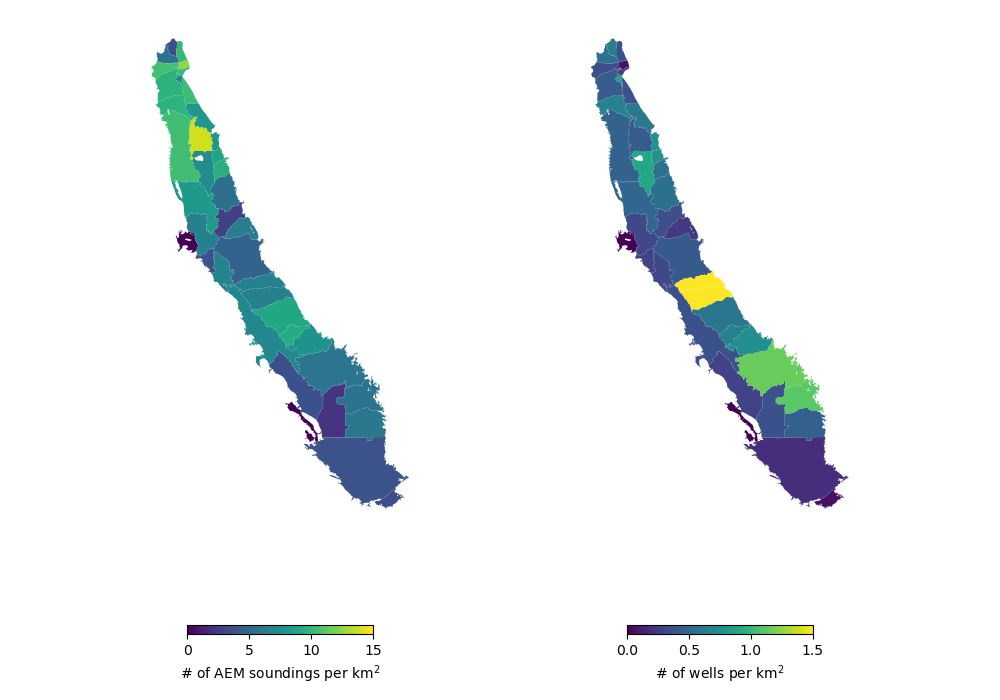

In [66]:
fig, axs = plt.subplots(1,2, figsize=(10, 7))
ax1, ax2 = axs
gdf_basins_3310_cv.plot(column='aem_density', cmap='viridis', ax=ax1, vmin=0, vmax=15, legend=True, legend_kwds={'label': "# of AEM soundings per km$^2$", 'fraction':0.015, 'orientation':'horizontal'})
gdf_basins_3310_cv.plot(column='sed_density', cmap='viridis', ax=ax2, vmin=0, vmax=1.5, legend=True, legend_kwds={'label': "# of wells per km$^2$", 'fraction':0.015, 'orientation':'horizontal'})
# fig.autofmt_xdate()
# gdf_basins_3310_cv.plot(column='wt_density', cmap='turbo', ax=ax3)
for ax in axs:
    ax.axis('off')
plt.tight_layout()

In [67]:
# gdf_basins_3310_cv_active = gdf_basins_3310_cv.loc[gdf_basins_3310_cv['aem_counts']!=0.]
# gdf_basins_3310_cv_active = gdf_basins_3310_cv_active.loc[gdf_basins_3310_cv['sed_counts']!=0.]

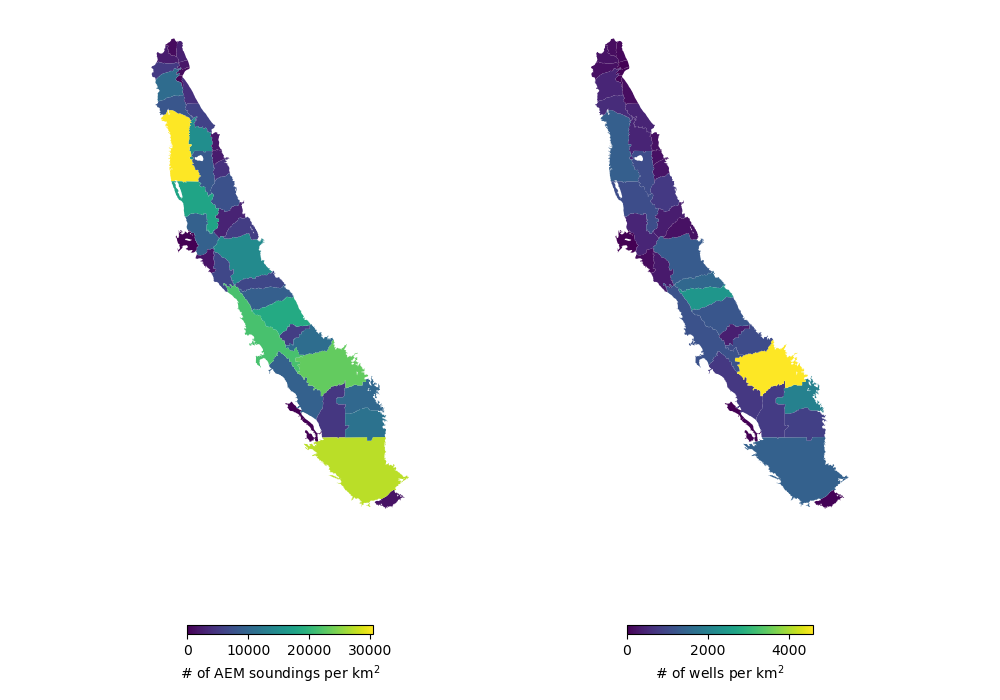

In [68]:
fig, axs = plt.subplots(1,2, figsize=(10, 7))
ax1, ax2 = axs
gdf_basins_3310_cv.plot(column='aem_counts', cmap='viridis', ax=ax1, legend=True, legend_kwds={'label': "# of AEM soundings per km$^2$", 'fraction':0.015, 'orientation':'horizontal'})
gdf_basins_3310_cv.plot(column='sed_counts', cmap='viridis', ax=ax2, legend=True, legend_kwds={'label': "# of wells per km$^2$", 'fraction':0.015, 'orientation':'horizontal'})
# fig.autofmt_xdate()
# gdf_basins_3310_cv.plot(column='wt_density', cmap='turbo', ax=ax3)
for ax in axs:
    ax.axis('off')
plt.tight_layout()

In [69]:
subbasin_names = gdf_basins_3310_cv['Basin_Su_1'].values
def foo(ii):    
    name = subbasin_names[ii]
    resistivity_tmp = em_data.resistivity[inds_aem_active,:][inds_aem_subbasin[name].flatten()]
    xy_aem_tmp = em_data.xy[inds_aem_active,:][inds_aem_subbasin[name].flatten()]
    hz_tmp = em_data.hz
    well_names_tmp = np.array(list(df_sediment_type.index))[inds_sed_subbasin[name].flatten()]
    xy_sed_tmp = df_sediment_type.loc[well_names_tmp][['UTMX', 'UTMY']].values
    gdf_basin_tmp = gdf_basins_3310_cv[gdf_basins_3310_cv['Basin_Su_1']==name]
    df_wt_tmp = df_waterlevel_survey.loc[np.array(list(df_waterlevel_survey.index))[inds_wt_subbasin[name].flatten()]]
    xy_wt_tmp = df_wt_tmp[['UTMX', 'UTMY']].values
    gse_wse_tmp = df_wt_tmp['GSE_WSE'].values

    fig, ax = plt.subplots(1,1)
    ax.plot(xy_sed_tmp[:,0], xy_sed_tmp[:,1], 'r.', ms=3)
    ax.plot(xy_aem_tmp[:,0], xy_aem_tmp[:,1], 'k.', ms=0.5)
    ax.plot(xy_wt_tmp[:,0], xy_wt_tmp[:,1], 'o', markerfacecolor='None', ms=3)
    ax.set_title(f"{ii:d}, {name}")
    gdf_basin_tmp.boundary.plot(ax=ax)
    # gdf_cv_3310.boundary.plot(ax=ax)
    ax.set_aspect(1)
    plt.show()
    plt.axis('off')
from ipywidgets import interact, widgets
interact(foo, ii=widgets.IntSlider(min=0, max=len(subbasin_names)-1, value=0))

interactive(children=(IntSlider(value=0, description='ii', max=40), Output()), _dom_classes=('widget-interact'…

<function __main__.foo(ii)>

In [70]:
# fig = plt.figure(10, 10)
# plt.scatter(xy_aem[:,0], xy_aem[:,1], c=water_table['wse_em'], s=0.01, vmin=0, vmax=100, alpha=0.5)
# plt.gca().set_aspect(1)
# plt.show()

In [71]:
from scipy.interpolate import NearestNDInterpolator
f_gse_wse = NearestNDInterpolator(xy_aem, water_table['wse_em'])

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
intervals = np.arange(61)*10
diff_matrix = np.ones((len(subbasin_names), len(intervals))) * np.nan
fd_std_matrix = np.ones((len(subbasin_names), len(intervals))) * np.nan
cd_std_matrix = np.ones((len(subbasin_names), len(intervals))) * np.nan
ncoloc_matrix = np.ones((len(subbasin_names), len(intervals))) * 0.

In [74]:
# verbose = True
# for ii, name in enumerate(subbasin_names):
#     resistivity_tmp = em_data.resistivity[inds_aem_active,:][inds_aem_subbasin[name].flatten()]
#     xy_aem_tmp = em_data.xy[inds_aem_active,:][inds_aem_subbasin[name].flatten()]
#     hz_tmp = em_data.hz
#     well_names_tmp = np.array(list(df_sediment_type.index))[inds_sed_subbasin[name].flatten()]
#     df_sediment_type_tmp = df_sediment_type.loc[well_names_tmp]

#     xy_sed_tmp = df_sediment_type.loc[well_names_tmp][['UTMX', 'UTMY']].values
#     gdf_basin_tmp = gdf_basins_3310_cv[gdf_basins_3310_cv['Basin_Su_1']==name]
#     df_wt_tmp = df_waterlevel_survey.loc[np.array(list(df_waterlevel_survey.index))[inds_wt_subbasin[name].flatten()]]
#     xy_wt_tmp = df_wt_tmp[['UTMX', 'UTMY']].values
#     # gse_wse_tmp = df_wt_tmp['GSE_WSE'].values
#     gse_wse_em_tmp = f_gse_wse(xy_aem_tmp)
#     group_interval = df_sediment_type_interval.groupby('WELL_ID')


#     n_wt = xy_wt_tmp.shape[0]
#     n_aem = xy_aem_tmp.shape[0]
#     n_sed = xy_sed_tmp.shape[0]
#     print (f"{name:s}, n_aem: {n_aem}, n_sed: {n_sed}, n_wt: {n_wt}")
    
#     if (n_wt==0) or (n_aem==0) or (n_sed==0):
#         print (f"{name:s}, n_aem: {n_aem}, n_sed: {n_sed}, n_wt: {n_wt}")
#         pass
#     else:
#         for kk, val in enumerate(intervals):
#             try: 
#                 colocations = compute_colocations(val, xy_aem_tmp, df_sediment_type_tmp)
#                 rock_physics_data = []
#                 rock_physics_well_names = []
#                 for i_sounding in range(len(colocations["inds_em"])):
#                     well_name = colocations["well_names"][i_sounding]
#                     rho_tmp = resistivity_tmp[colocations["inds_em"][i_sounding],:][:n_layer]
#                     df_driller_tmp = group_interval.get_group(well_name)
#                     inds_sort = np.argsort(df_driller_tmp['top_meter'].values)
#                     z_top = df_driller_tmp['top_meter'].values[inds_sort]
#                     z_bot = df_driller_tmp['bottom_meter'].values[inds_sort]
#                     code_tmp = df_driller_tmp['coarse_fraction'].values.astype(float)[inds_sort]
#                     lith_data = pd.DataFrame(data=np.c_[z_top, z_bot, code_tmp], columns=['From', 'To', 'Code'])
#                     fraction = compute_fraction_for_aem_layer(hz_tmp[:n_layer], lith_data)
#                     depth = np.cumsum(np.r_[0, hz_tmp[:n_layer]])
#                     top = depth[:-1]
#                     bottom = depth[1:]
#                     rock_physics_data.append(np.c_[top, bottom, fraction, rho_tmp])
#                     rock_physics_well_names.append(np.array([well_name] * n_layer))

#                 rock_physics_data = np.vstack(rock_physics_data)
#                 rock_physics_well_names = np.hstack(rock_physics_well_names)
#                 df_rock_physics_data = pd.DataFrame(data=rock_physics_data, columns=['top', 'bottom', 'f_fine', 'f_coarse', 'rho_aem'])
#                 df_rock_physics_data['well_names'] = rock_physics_well_names
#                 gse_wse = np.repeat(gse_wse_em_tmp[colocations["inds_em"]], n_layer)
#                 df_rock_physics_data['gse_wse'] = gse_wse
#                 df_rock_physics_data_filtered = df_rock_physics_data[np.logical_and(~np.isnan(df_rock_physics_data['f_fine']), ~np.isnan(df_rock_physics_data['rho_aem']))]

#                 n_bootstrap = 1000
#                 rho_above_integral, rho_int_above, cf_int_above = compute_integral(df_rock_physics_data_filtered, n_bootstrap=n_bootstrap)    
#                 rho_above_integral = np.clip(rho_above_integral, 1, 1000)

#                 rho_fine_above_integral = np.percentile(rho_above_integral[:,0], 50)
#                 rho_coarse_above_integral = np.percentile(rho_above_integral[:,1], 50)
#                 diff = np.log10(rho_coarse_above_integral)-np.log10(rho_fine_above_integral)
#                 fd_std = np.std(np.log10(rho_above_integral[:,0]))
#                 fd_std_matrix[ii, kk] = fd_std
#                 cd_std = np.std(np.log10(rho_above_integral[:,1]))
#                 cd_std_matrix[ii, kk] = cd_std                
#                 diff_matrix[ii, kk] = diff
#                 ncoloc = len(colocations["well_names"])
#                 ncoloc_matrix[ii, kk] = ncoloc
#                 if verbose:
#                     print(f"{val:.0f}, {rho_fine_above_integral:.1f}, {rho_coarse_above_integral:.1f}, {diff:.2f}, {ncoloc}")
#         #         data_integral = np.c_[rho_above_integral]

#         #         columns = [
#         #             'rho_fine_dominated_above', 
#         #             'rho_coarse_dominated_above',
#         #         ]

#         #         df_rho_distribution_integral = pd.DataFrame(data=data_integral, columns=columns)
#         #         rockphysics_dict[name] = df_rho_distribution_integral
#             except:
#                 if verbose:
#                     print(f"{val:.0f}, did not work")
#                 pass

In [75]:
# diff_matrix

In [76]:
# results = {
#     'ncoloc_matrix':ncoloc_matrix, 
#     'diff_matrix':diff_matrix, 
#     'fd_std_matrix':fd_std_matrix, 
#     'cd_std_matrix':cd_std_matrix, 
#     'intervals':intervals, 
#     'subbasin_names':subbasin_names
# }
# dill.dump(results, open("global_search_results.pik", "wb"))

In [77]:
results = dill.load(open("global_search_results.pik", "rb"))

In [78]:
ncoloc_matrix = results['ncoloc_matrix'] 
diff_matrix = results['diff_matrix'] 
fd_std_matrix = results['fd_std_matrix'] 
cd_std_matrix = results['cd_std_matrix'] 
intervals = results['intervals'] 
subbasin_names = results['subbasin_names'] 

In [79]:
fd_std_matrix

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.03734553, 0.03786154,
        0.03760463],
       ...,
       [       nan,        nan, 0.42244673, ..., 0.01586238, 0.01513594,
        0.01569868],
       [       nan,        nan, 0.68870863, ..., 0.02167985, 0.02076468,
        0.02044879],
       [       nan,        nan, 0.        , ..., 0.02251975, 0.02191073,
        0.02128641]])

In [80]:
gdf_basins_3310_cv['num_coloc_max'] = ncoloc_matrix.max(axis=1)

In [81]:
fd_std_matrix_filt = fd_std_matrix.copy()
cd_std_matrix_filt = cd_std_matrix.copy()
fd_std_matrix_filt[np.isnan(fd_std_matrix)] = 0.
cd_std_matrix_filt[np.isnan(cd_std_matrix)] = 0.

In [82]:
fd_std_matrix_filt

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03734553, 0.03786154,
        0.03760463],
       ...,
       [0.        , 0.        , 0.42244673, ..., 0.01586238, 0.01513594,
        0.01569868],
       [0.        , 0.        , 0.68870863, ..., 0.02167985, 0.02076468,
        0.02044879],
       [0.        , 0.        , 0.        , ..., 0.02251975, 0.02191073,
        0.02128641]])

In [83]:
# fig = plt.figure()
# plt.hist(fd_std_matrix[~np.isnan(fd_std_matrix)], bins=100)
# plt.show()

In [84]:
diff_matrix_filt = diff_matrix.copy()
min_colocs = 100
diff_matrix_filt[fd_std_matrix_filt>0.2] = np.nan
diff_matrix_filt[cd_std_matrix_filt>0.2] = np.nan
diff_matrix_filt[diff_matrix<0.] = np.nan
diff_matrix_filt[ncoloc_matrix<=min_colocs] = np.nan
diff_matrix_filt[np.isnan(diff_matrix_filt)] = 0.
inds_opt = np.argmax(diff_matrix_filt, axis=1)
opt_distance = np.zeros(len(subbasin_names)) * np.nan
opt_colocs = np.zeros(len(subbasin_names)) * np.nan
for ii, ind in enumerate(inds_opt):
    if ind != 0:
        opt_distance[ii] = intervals[ind]
        opt_colocs[ii] = ncoloc_matrix[ii, ind]

In [85]:
inds_opt

array([ 0,  0,  0,  0,  0,  0, 55,  0,  0,  0, 17, 34, 54,  0,  0,  0, 46,
       58,  0, 36, 56, 27, 30, 28, 21, 59, 32,  9,  0,  0,  0,  0,  0,  0,
       35, 39, 60, 53, 26, 41, 31])

In [86]:
opt_colocs[~np.isnan(opt_colocs)].min()

103.0

In [87]:
opt_colocs[~np.isnan(opt_colocs)].max()

480.0

In [88]:
opt_colocs[~np.isnan(opt_colocs)].mean()

195.4090909090909

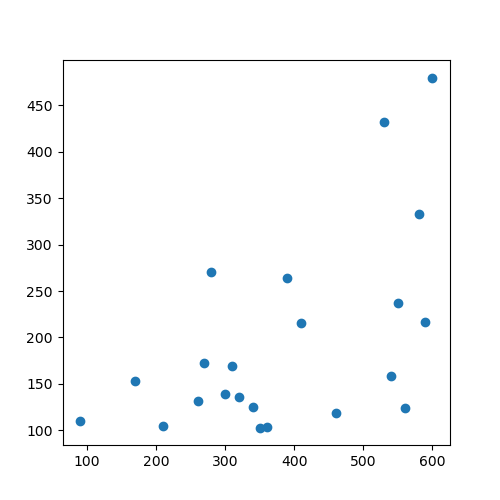

In [89]:
fig = plt.figure(figsize=(5,5))
# plt.scatter(opt_distance, gdf_basins_3310_cv['aem_counts'])
plt.scatter(opt_distance, opt_colocs)
# plt.scatter(opt_distance, gdf_basins_3310_cv['sed_counts'])
ax = plt.gca()
# ax.set_aspect(0.015)
plt.show()

In [90]:
gdf_basins_3310_cv['opt_coloc_distance'] = opt_distance

In [91]:
opt_distance.shape

(41,)

In [92]:
gdf_basins_3310_cv.shape

(41, 14)

In [93]:
rock_physics_dict_all_subbasins  = {}
for ii, name in enumerate(subbasin_names):
    rock_physics_dict = {}
    resistivity_tmp = em_data.resistivity[inds_aem_active,:][inds_aem_subbasin[name].flatten()]
    xy_aem_tmp = em_data.xy[inds_aem_active,:][inds_aem_subbasin[name].flatten()]
    hz_tmp = em_data.hz
    well_names_tmp = np.array(list(df_sediment_type.index))[inds_sed_subbasin[name].flatten()]
    df_sediment_type_tmp = df_sediment_type.loc[well_names_tmp]

    xy_sed_tmp = df_sediment_type.loc[well_names_tmp][['UTMX', 'UTMY']].values
    gdf_basin_tmp = gdf_basins_3310_cv[gdf_basins_3310_cv['Basin_Su_1']==name]
    df_wt_tmp = df_waterlevel_survey.loc[np.array(list(df_waterlevel_survey.index))[inds_wt_subbasin[name].flatten()]]
    xy_wt_tmp = df_wt_tmp[['UTMX', 'UTMY']].values
    # gse_wse_tmp = df_wt_tmp['GSE_WSE'].values
    gse_wse_em_tmp = f_gse_wse(xy_aem_tmp)
    group_interval = df_sediment_type_interval.groupby('WELL_ID')
    val = opt_distance[ii]
    if ~np.isnan(val):
        colocations = compute_colocations(val, xy_aem_tmp, df_sediment_type_tmp)
        rock_physics_data = []
        rock_physics_well_names = []
        for i_sounding in range(len(colocations["inds_em"])):
            well_name = colocations["well_names"][i_sounding]
            rho_tmp = resistivity_tmp[colocations["inds_em"][i_sounding],:][:n_layer]
            df_driller_tmp = group_interval.get_group(well_name)
            inds_sort = np.argsort(df_driller_tmp['top_meter'].values)
            z_top = df_driller_tmp['top_meter'].values[inds_sort]
            z_bot = df_driller_tmp['bottom_meter'].values[inds_sort]
            code_tmp = df_driller_tmp['coarse_fraction'].values.astype(float)[inds_sort]
            lith_data = pd.DataFrame(data=np.c_[z_top, z_bot, code_tmp], columns=['From', 'To', 'Code'])
            fraction = compute_fraction_for_aem_layer(hz_tmp[:n_layer], lith_data)
            depth = np.cumsum(np.r_[0, hz_tmp[:n_layer]])
            top = depth[:-1]
            bottom = depth[1:]
            rock_physics_data.append(np.c_[top, bottom, fraction, rho_tmp])
            rock_physics_well_names.append(np.array([well_name] * n_layer))

        rock_physics_data = np.vstack(rock_physics_data)
        rock_physics_well_names = np.hstack(rock_physics_well_names)
        df_rock_physics_data = pd.DataFrame(data=rock_physics_data, columns=['top', 'bottom', 'f_fine', 'f_coarse', 'rho_aem'])
        df_rock_physics_data['well_names'] = rock_physics_well_names
        gse_wse = np.repeat(gse_wse_em_tmp[colocations["inds_em"]], n_layer)
        df_rock_physics_data['gse_wse'] = gse_wse
        df_rock_physics_data_filtered = df_rock_physics_data[np.logical_and(~np.isnan(df_rock_physics_data['f_fine']), ~np.isnan(df_rock_physics_data['rho_aem']))]

        n_bootstrap = 1000
        rho_above_integral, rho_int_above, cf_int_above = compute_integral(df_rock_physics_data_filtered, n_bootstrap=n_bootstrap)    
        rho_above_integral = np.clip(rho_above_integral, 1, 1000)

        rho_fine_above_integral = np.percentile(rho_above_integral[:,0], 50)
        rho_coarse_above_integral = np.percentile(rho_above_integral[:,1], 50)

        diff = np.log10(rho_coarse_above_integral)-np.log10(rho_fine_above_integral)
        std_cd = np.std(np.log10(rho_above_integral[:,1]))
        std_fd = np.std(np.log10(rho_above_integral[:,0]))
        ncoloc = len(colocations["well_names"])
        print(f"{name}, {val:.0f}, {rho_fine_above_integral:.1f}, {rho_coarse_above_integral:.1f}, {diff:.2f}, {std_fd:.2f}, {std_cd:.2f}, {ncoloc}")        
        data_integral = np.c_[rho_above_integral]
        
        columns = [
            'rho_fine_dominated_above', 
            'rho_coarse_dominated_above',
        ]

        df_rho_distribution_integral = pd.DataFrame(data=data_integral, columns=columns)
        rock_physics_dict['df_rho_distribution_integral'] = df_rho_distribution_integral
        rock_physics_dict['df_rock_physics_data_filtered'] = df_rock_physics_data_filtered
        rock_physics_dict['ncoloc'] = ncoloc
        rock_physics_dict['rho_fine_50th'] = rho_fine_above_integral
        rock_physics_dict['rho_coarse_50th'] = rho_coarse_above_integral
        rock_physics_dict_all_subbasins[name] = rock_physics_dict

SACRAMENTO VALLEY - BUTTE, 550, 19.1, 54.7, 0.46, 0.03, 0.11, 237
SACRAMENTO VALLEY - COLUSA, 170, 13.1, 43.7, 0.52, 0.03, 0.08, 145
SACRAMENTO VALLEY - CORNING, 340, 13.9, 24.4, 0.24, 0.03, 0.05, 125
SACRAMENTO VALLEY - SOLANO, 540, 10.8, 14.3, 0.12, 0.02, 0.06, 159
SACRAMENTO VALLEY - NORTH AMERICAN, 460, 12.9, 16.4, 0.10, 0.01, 0.05, 119
SACRAMENTO VALLEY - SUTTER, 580, 18.1, 27.3, 0.18, 0.03, 0.07, 333
SACRAMENTO VALLEY - RED BLUFF, 360, 15.7, 20.6, 0.12, 0.02, 0.05, 104
SACRAMENTO VALLEY - VINA, 560, 15.2, 23.4, 0.19, 0.02, 0.04, 124
SACRAMENTO VALLEY - YOLO, 270, 10.4, 16.0, 0.18, 0.02, 0.04, 172
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN, 300, 17.5, 22.0, 0.10, 0.03, 0.05, 139
SAN JOAQUIN VALLEY - KAWEAH, 280, 16.6, 25.0, 0.18, 0.03, 0.04, 270
SAN JOAQUIN VALLEY - WESTSIDE, 210, 7.5, 8.8, 0.07, 0.03, 0.05, 51
SAN JOAQUIN VALLEY - MODESTO, 590, 22.1, 23.6, 0.03, 0.03, 0.04, 217
SAN JOAQUIN VALLEY - TULARE LAKE, 320, 20.7, 25.0, 0.08, 0.09, 0.12, 96
SAN JOAQUIN VALLEY - KINGS, 90, 1

In [94]:
# len(subbasin_names_active)

In [95]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
subbasin_names_active = list(rock_physics_dict_all_subbasins.keys())
def foo(ii):    
    name = subbasin_names_active[ii]
    rock_physics_dict = rock_physics_dict_all_subbasins[name]
    df_tmp = rock_physics_dict['df_rho_distribution_integral']
    rho_fine_above = df_tmp['rho_fine_dominated_above'].values
    rho_coarse_above = df_tmp['rho_coarse_dominated_above'].values

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    xlim = np.log10((10, 50))
    out = ax.hist(np.log10(rho_fine_above[rho_fine_above<1000.]), bins=np.linspace(xlim[0], xlim[1], 100), density=True, label='Fine-dominated', edgecolor='k', alpha=0.5, color='b')
    out = ax.hist(np.log10(rho_coarse_above[rho_coarse_above<1000.]), bins=np.linspace(xlim[0], xlim[1], 100), density=True, label='Coarse-dominated', edgecolor='k', alpha=0.5, color='crimson')
    ax.legend()

    xticks =ax.get_xticks()

    ax.set_ylabel("Probability density")
    ax.set_xlim(xlim)

    ax.set_xticks(xticks)
    ax.set_xticklabels(["{:.0f}".format(10**x) for x in xticks])
    ax.set_title(name)
    plt.show()
    plt.tight_layout()

from ipywidgets import interact, widgets
interact(foo, ii=widgets.IntSlider(min=0, max=len(subbasin_names_active)-1, value=0))
# ax.set_ylim(0, 100)

interactive(children=(IntSlider(value=0, description='ii', max=21), Output()), _dom_classes=('widget-interact'…

<function __main__.foo(ii)>

In [96]:
gdf_basins_3310_cv_active = gdf_basins_3310_cv.set_index('Basin_Su_1', inplace=False).loc[subbasin_names_active]

In [97]:
gdf_basins_3310_cv_active

Basin_Name Basin_Subb  \
Basin_Su_1                                                                
SACRAMENTO VALLEY - BUTTE                  SACRAMENTO VALLEY   5-021.70   
SACRAMENTO VALLEY - COLUSA                 SACRAMENTO VALLEY   5-021.52   
SACRAMENTO VALLEY - CORNING                SACRAMENTO VALLEY   5-021.51   
SACRAMENTO VALLEY - SOLANO                 SACRAMENTO VALLEY   5-021.66   
SACRAMENTO VALLEY - NORTH AMERICAN         SACRAMENTO VALLEY   5-021.64   
SACRAMENTO VALLEY - SUTTER                 SACRAMENTO VALLEY   5-021.62   
SACRAMENTO VALLEY - RED BLUFF              SACRAMENTO VALLEY   5-021.50   
SACRAMENTO VALLEY - VINA                   SACRAMENTO VALLEY   5-021.57   
SACRAMENTO VALLEY - YOLO                   SACRAMENTO VALLEY   5-021.67   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  SAN JOAQUIN VALLEY   5-022.01   
SAN JOAQUIN VALLEY - KAWEAH               SAN JOAQUIN VALLEY   5-022.11   
SAN JOAQUIN VALLEY - WESTSIDE             SAN JOAQUIN VALLEY   5-022.09   
SAN JOAQUIN VALLEY - MODESTO              SAN JOAQUIN VALLEY   5-022.02   
SAN JOAQUIN VALLEY - TULARE LAKE          SAN JOAQUIN VALLEY   5-022.12   
SAN JOAQUIN VALLEY - KINGS                SAN JOAQUIN VALLEY   5-022.08   
SAN JOAQUIN VALLEY - CHOWCHILLA           SAN JOAQUIN VALLEY   5-022.05   
SAN JOAQUIN VALLEY - TURLOCK              SAN JOAQUIN VALLEY   5-022.03   
SAN JOAQUIN VALLEY - KERN COUNTY          SAN JOAQUIN VALLEY   5-022.14   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        SAN JOAQUIN VALLEY   5-022.07   
SAN JOAQUIN VALLEY - MERCED               SAN JOAQUIN VALLEY   5-022.04   
SAN JOAQUIN VALLEY - MADERA               SAN JOAQUIN VALLEY   5-022.06   
SAN JOAQUIN VALLEY - TULE                 SAN JOAQUIN VALLEY   5-022.13   

                                                                                   geometry  \
Basin_Su_1                                                                                    
SACRAMENTO VALLEY - BUTTE                 POLYGON ((-141696.413 168792.474, -141582.646 ...   
SACRAMENTO VALLEY - COLUSA                POLYGON ((-201099.430 198414.491, -201101.522 ...   
SACRAMENTO VALLEY - CORNING               POLYGON ((-178785.899 221125.977, -178819.685 ...   
SACRAMENTO VALLEY - SOLANO                POLYGON ((-163707.123 59610.571, -163715.429 5...   
SACRAMENTO VALLEY - NORTH AMERICAN        POLYGON ((-115741.598 114376.386, -115744.243 ...   
SACRAMENTO VALLEY - SUTTER                POLYGON ((-151889.846 144547.041, -153474.188 ...   
SACRAMENTO VALLEY - RED BLUFF             POLYGON ((-183037.412 256386.584, -183007.205 ...   
SACRAMENTO VALLEY - VINA                  POLYGON ((-174832.986 209448.925, -174832.976 ...   
SACRAMENTO VALLEY - YOLO                  POLYGON ((-190091.582 103204.233, -190077.609 ...   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  POLYGON ((-89815.421 32013.071, -89855.555 319...   
SAN JOAQUIN VALLEY - KAWEAH               MULTIPOLYGON (((45429.555 -179439.902, 45448.1...   
SAN JOAQUIN VALLEY - WESTSIDE             POLYGON ((-23380.493 -158694.385, -23530.863 -...   
SAN JOAQUIN VALLEY - MODESTO              POLYGON ((-40193.377 -38980.697, -40079.575 -3...   
SAN JOAQUIN VALLEY - TULARE LAKE          POLYGON ((42208.347 -172913.002, 42207.366 -17...   
SAN JOAQUIN VALLEY - KINGS                POLYGON ((26247.097 -117001.046, 26206.900 -11...   
SAN JOAQUIN VALLEY - CHOWCHILLA           POLYGON ((-30775.001 -92300.000, -32367.248 -9...   
SAN JOAQUIN VALLEY - TURLOCK              POLYGON ((-40199.880 -38975.472, -40206.288 -3...   
SAN JOAQUIN VALLEY - KERN COUNTY          POLYGON ((96298.618 -246860.668, 96291.161 -24...   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        POLYGON ((-122322.254 -37925.856, -122310.776 ...   
SAN JOAQUIN VALLEY - MERCED               MULTIPOLYGON (((-5486.395 -93019.690, -5457.13...   
SAN JOAQUIN VALLEY - MADERA               POLYGON ((-4537.847 -92544.938, -4562.016 -925...   
SAN JOAQUIN VALLEY - TULE                 POLYGON ((73032.797 -2

In [98]:
rho_fines_50th = []
rho_coarses_50th = []
ncolocs = []
for name in subbasin_names_active:
    rock_physics_dict = rock_physics_dict_all_subbasins[name]
    rho_fines_50th.append(rock_physics_dict['rho_fine_50th'])
    rho_coarses_50th.append(rock_physics_dict['rho_coarse_50th'])
    ncolocs.append(rock_physics_dict['ncoloc'])
    # rock_physics_dict['rho]]
rho_coarses_50th = np.array(rho_coarses_50th)
rho_fines_50th = np.array(rho_fines_50th)

In [99]:
ncolocs

[237,
 145,
 125,
 159,
 119,
 333,
 104,
 124,
 172,
 139,
 270,
 51,
 217,
 96,
 110,
 103,
 264,
 462,
 395,
 132,
 216,
 159]

In [100]:
subbasin_names_active = np.array(subbasin_names_active)

In [101]:
subbasin_names_inactive = subbasin_names[~np.in1d(subbasin_names, subbasin_names_active)]

In [102]:
gdf_basins_3310_cv

Basin_Name                                Basin_Su_1  \
336  SUISUN-FAIRFIELD VALLEY                   SUISUN-FAIRFIELD VALLEY   
394             REDDING AREA         REDDING AREA - SOUTH BATTLE CREEK   
395             REDDING AREA                   REDDING AREA - ANDERSON   
396             REDDING AREA                 REDDING AREA - ENTERPRISE   
397             REDDING AREA                  REDDING AREA - MILLVILLE   
398             REDDING AREA                     REDDING AREA - BOWMAN   
439        SACRAMENTO VALLEY                 SACRAMENTO VALLEY - BUTTE   
440        SACRAMENTO VALLEY                  SACRAMENTO VALLEY - BEND   
441        SACRAMENTO VALLEY       SACRAMENTO VALLEY - WYANDOTTE CREEK   
442        SACRAMENTO VALLEY              SACRAMENTO VALLEY - ANTELOPE   
443        SACRAMENTO VALLEY                SACRAMENTO VALLEY - COLUSA   
444        SACRAMENTO VALLEY               SACRAMENTO VALLEY - CORNING   
445        SACRAMENTO VALLEY                SACRAMENTO VALLEY - SOLANO   
446        SACRAMENTO VALLEY            SACRAMENTO VALLEY - SOUTH YUBA   
447        SACRAMENTO VALLEY            SACRAMENTO VALLEY - NORTH YUBA   
448        SACRAMENTO VALLEY        SACRAMENTO VALLEY - SOUTH AMERICAN   
449        SACRAMENTO VALLEY        SACRAMENTO VALLEY - NORTH AMERICAN   
450        SACRAMENTO VALLEY                SACRAMENTO VALLEY - SUTTER   
451        SACRAMENTO VALLEY           SACRAMENTO VALLEY - LOS MOLINOS   
452        SACRAMENTO VALLEY             SACRAMENTO VALLEY - RED BLUFF   
453        SACRAMENTO VALLEY                  SACRAMENTO VALLEY - VINA   
454        SACRAMENTO VALLEY                  SACRAMENTO VALLEY - YOLO   
462       SAN JOAQUIN VALLEY  SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN   
463       SAN JOAQUIN VALLEY               SAN JOAQUIN VALLEY - KAWEAH   
464       SAN JOAQUIN VALLEY             SAN JOAQUIN VALLEY - WESTSIDE   
465       SAN JOAQUIN VALLEY              SAN JOAQUIN VALLEY - MODESTO   
466       SAN JOAQUIN VALLEY          SAN JOAQUIN VALLEY - TULARE LAKE   
467       SAN JOAQUIN VALLEY                SAN JOAQUIN VALLEY - KINGS   
468       SAN JOAQUIN VALLEY      SAN JOAQUIN VALLEY - KETTLEMAN PLAIN   
469       SAN JOAQUIN VALLEY           SAN JOAQUIN VALLEY - WHITE WOLF   
470       SAN JOAQUIN VALLEY      SAN JOAQUIN VALLEY - PLEASANT VALLEY   
471       SAN JOAQUIN VALLEY             SAN JOAQUIN VALLEY - COSUMNES   
472       SAN JOAQUIN VALLEY    SAN JOAQUIN VALLEY - EAST CONTRA COSTA   
473       SAN JOAQUIN VALLEY                SAN JOAQUIN VALLEY - TRACY   
474       SAN JOAQUIN VALLEY           SAN JOAQUIN VALLEY - CHOWCHILLA   
475       SAN JOAQUIN VALLEY              SAN JOAQUIN VALLEY - TURLOCK   
476       SAN JOAQUIN VALLEY          SAN JOAQUIN VALLEY - KERN COUNTY   
477       SAN JOAQUIN VALLEY        SAN JOAQUIN VALLEY - DELTA-MENDOTA   
478       SAN JOAQUIN VALLEY               SAN JOAQUIN VALLEY - MERCED   
479       SAN JOAQUIN VALLEY               SAN JOAQUIN VALLEY - MADERA   
480       SAN JOAQUIN VALLEY                 SAN JOAQUIN VALLEY - TULE   

    Basin_Subb                                           geometry  \
336      2-003  POLYGON ((-169711.205 34389.173, -169754.944 3...   
394   5-006.06  POLYGON ((-173976.773 268986.135, -173979.405 ...   
395   5-006.03  POLYGON ((-201019.836 286447.775, -200874.210 ...   
396   5-006.04  POLYGON ((-189028.759 294154.862, -189150.478 ...   
397   5-006.05  POLYGON ((-182227.698 294491.341, -182419.810 ...   
398   5-006.01  POLYGON ((-213411.896 266435.489, -213422.122 ...   
439   5-021.70  POLYGON ((-141696.413 168792.474, -141582.646 ...   
440   5-021.53  POLYGON ((-180608.392 248075.986, -180162.988 ...   
441   5-021.69  POLYGON ((-132012.177 167512.873, -132325.875 ...   
442   5-021.54  POLYGON ((-180567.873 245514.041, -180793.230 ...   
443   5-021.52  POLYGON ((-201099.430 198414.491, -201101.522 ...   
444   5-021.51  POLYGON ((-178785.899 221125.977, -178819.685 ...   
445   5-021.

In [103]:
# rho_coarses_50th[subbasin_names_active ==  'SAN JOAQUIN VALLEY - TULARE LAKE'] = np.nan

In [104]:
gdf_basins_3310_cv_active['rho_fine_50th'] = rho_fines_50th
gdf_basins_3310_cv_active['rho_coarse_50th'] = rho_coarses_50th
gdf_basins_3310_cv_active['ncolocs'] = ncolocs

In [105]:
gdf_basins_3310_cv_active

Basin_Name Basin_Subb  \
Basin_Su_1                                                                
SACRAMENTO VALLEY - BUTTE                  SACRAMENTO VALLEY   5-021.70   
SACRAMENTO VALLEY - COLUSA                 SACRAMENTO VALLEY   5-021.52   
SACRAMENTO VALLEY - CORNING                SACRAMENTO VALLEY   5-021.51   
SACRAMENTO VALLEY - SOLANO                 SACRAMENTO VALLEY   5-021.66   
SACRAMENTO VALLEY - NORTH AMERICAN         SACRAMENTO VALLEY   5-021.64   
SACRAMENTO VALLEY - SUTTER                 SACRAMENTO VALLEY   5-021.62   
SACRAMENTO VALLEY - RED BLUFF              SACRAMENTO VALLEY   5-021.50   
SACRAMENTO VALLEY - VINA                   SACRAMENTO VALLEY   5-021.57   
SACRAMENTO VALLEY - YOLO                   SACRAMENTO VALLEY   5-021.67   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  SAN JOAQUIN VALLEY   5-022.01   
SAN JOAQUIN VALLEY - KAWEAH               SAN JOAQUIN VALLEY   5-022.11   
SAN JOAQUIN VALLEY - WESTSIDE             SAN JOAQUIN VALLEY   5-022.09   
SAN JOAQUIN VALLEY - MODESTO              SAN JOAQUIN VALLEY   5-022.02   
SAN JOAQUIN VALLEY - TULARE LAKE          SAN JOAQUIN VALLEY   5-022.12   
SAN JOAQUIN VALLEY - KINGS                SAN JOAQUIN VALLEY   5-022.08   
SAN JOAQUIN VALLEY - CHOWCHILLA           SAN JOAQUIN VALLEY   5-022.05   
SAN JOAQUIN VALLEY - TURLOCK              SAN JOAQUIN VALLEY   5-022.03   
SAN JOAQUIN VALLEY - KERN COUNTY          SAN JOAQUIN VALLEY   5-022.14   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        SAN JOAQUIN VALLEY   5-022.07   
SAN JOAQUIN VALLEY - MERCED               SAN JOAQUIN VALLEY   5-022.04   
SAN JOAQUIN VALLEY - MADERA               SAN JOAQUIN VALLEY   5-022.06   
SAN JOAQUIN VALLEY - TULE                 SAN JOAQUIN VALLEY   5-022.13   

                                                                                   geometry  \
Basin_Su_1                                                                                    
SACRAMENTO VALLEY - BUTTE                 POLYGON ((-141696.413 168792.474, -141582.646 ...   
SACRAMENTO VALLEY - COLUSA                POLYGON ((-201099.430 198414.491, -201101.522 ...   
SACRAMENTO VALLEY - CORNING               POLYGON ((-178785.899 221125.977, -178819.685 ...   
SACRAMENTO VALLEY - SOLANO                POLYGON ((-163707.123 59610.571, -163715.429 5...   
SACRAMENTO VALLEY - NORTH AMERICAN        POLYGON ((-115741.598 114376.386, -115744.243 ...   
SACRAMENTO VALLEY - SUTTER                POLYGON ((-151889.846 144547.041, -153474.188 ...   
SACRAMENTO VALLEY - RED BLUFF             POLYGON ((-183037.412 256386.584, -183007.205 ...   
SACRAMENTO VALLEY - VINA                  POLYGON ((-174832.986 209448.925, -174832.976 ...   
SACRAMENTO VALLEY - YOLO                  POLYGON ((-190091.582 103204.233, -190077.609 ...   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  POLYGON ((-89815.421 32013.071, -89855.555 319...   
SAN JOAQUIN VALLEY - KAWEAH               MULTIPOLYGON (((45429.555 -179439.902, 45448.1...   
SAN JOAQUIN VALLEY - WESTSIDE             POLYGON ((-23380.493 -158694.385, -23530.863 -...   
SAN JOAQUIN VALLEY - MODESTO              POLYGON ((-40193.377 -38980.697, -40079.575 -3...   
SAN JOAQUIN VALLEY - TULARE LAKE          POLYGON ((42208.347 -172913.002, 42207.366 -17...   
SAN JOAQUIN VALLEY - KINGS                POLYGON ((26247.097 -117001.046, 26206.900 -11...   
SAN JOAQUIN VALLEY - CHOWCHILLA           POLYGON ((-30775.001 -92300.000, -32367.248 -9...   
SAN JOAQUIN VALLEY - TURLOCK              POLYGON ((-40199.880 -38975.472, -40206.288 -3...   
SAN JOAQUIN VALLEY - KERN COUNTY          POLYGON ((96298.618 -246860.668, 96291.161 -24...   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        POLYGON ((-122322.254 -37925.856, -122310.776 ...   
SAN JOAQUIN VALLEY - MERCED               MULTIPOLYGON (((-5486.395 -93019.690, -5457.13...   
SAN JOAQUIN VALLEY - MADERA               POLYGON ((-4537.847 -92544.938, -4562.016 -925...   
SAN JOAQUIN VALLEY - TULE                 POLYGON ((73032.797 -2

In [106]:
from matplotlib import colors

In [107]:
from matplotlib.colors import LogNorm
import rasterio
from rasterio.plot import show
src = rasterio.open("./cv_terrain.tiff")

In [108]:
gdf_rivers = gpd.read_file("./cv_rivers.geojson")
gdf_rivers_3310 = gdf_rivers.to_crs(3310)

In [109]:
gdf_rho_salinity = gpd.read_file("./resistivity_contours_6ohmm.geojson")

In [110]:
# color_dict = {'Africa':'orange', 'Antarctica':'white', 'Asia':'pink', 
#               'Europe':'green', 'North America':'brown',
#               'Oceania':'blue', 'Seven seas (open ocean)':'gray',
#               'South America':'red'}


# fig, ax = plt.subplots(figsize=(15,10))
# gdf.plot(ax=ax, column="continent", legend=True)
# plt.axis('off')

In [111]:
color_dict = {}
for ii in list(gdf_rho_salinity.index):
    color_dict[ii] = 'grey'

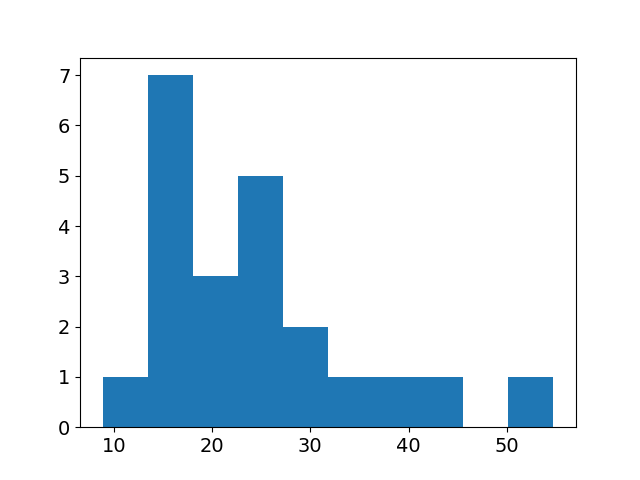

In [112]:
fig = plt.figure()
plt.hist(gdf_basins_3310_cv_active['rho_coarse_50th'].values)
plt.show()

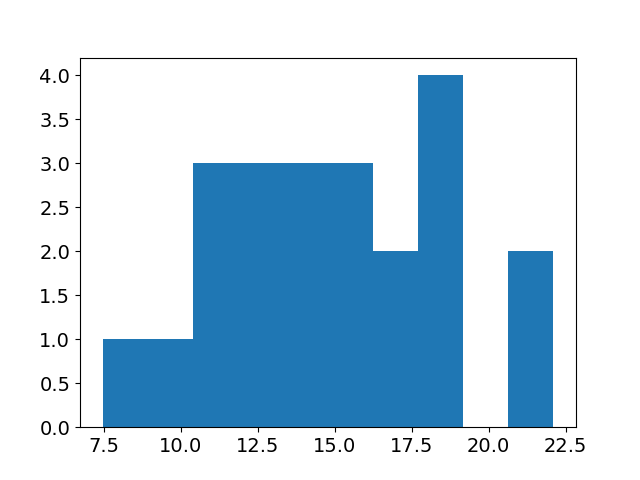

In [113]:
fig = plt.figure()
plt.hist(gdf_basins_3310_cv_active['rho_fine_50th'].values)
plt.show()

In [114]:
print(np.percentile(gdf_basins_3310_cv_active['rho_fine_50th'].values, 5))
print (np.percentile(gdf_basins_3310_cv_active['rho_fine_50th'].values, 95))

10.311417087507241
20.632518114881517


In [115]:
print(np.percentile(gdf_basins_3310_cv_active['rho_coarse_50th'].values, 5))
print (np.percentile(gdf_basins_3310_cv_active['rho_coarse_50th'].values, 95))

14.336265299553395
43.38620800056603


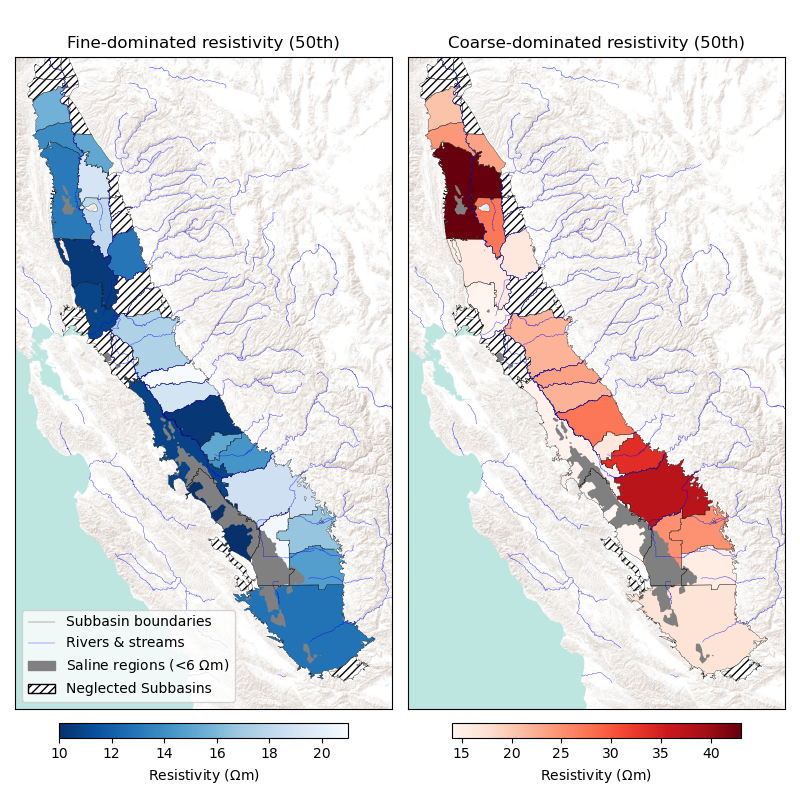

In [116]:
import matplotlib
matplotlib.rcParams['font.size'] = 10
legend_kwds = {'fraction':0.02, 'pad':0.02, 'orientation':'horizontal', 'label':'Resistivity ($\Omega$m)'}

fig, axs = plt.subplots(1,2, figsize=(8, 8))
ax1, ax2 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
show(src, ax=ax1)
show(src, ax=ax2)
gdf_basins_3310_cv_active.plot(
    column='rho_fine_50th', cmap='Blues_r', ax=ax1, legend=True, legend_kwds=legend_kwds,
    vmin=10, vmax=21,
)
out = gdf_basins_3310_cv_active.plot(
    column='rho_coarse_50th', cmap='Reds', ax=ax2, legend=True, legend_kwds=legend_kwds,
    vmin=14, vmax=43,
)

for ax in axs:
    gdf_basins_3310_cv.set_index('Basin_Su_1',inplace=False).loc[subbasin_names_inactive].plot(ax=ax, color='w', hatch='////')
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    gdf_basins_3310_cv.boundary.plot(color='k', linewidth=0.2, ax=ax, label='Subbasin boundaries')
    gdf_rivers_3310.plot(color='b', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("")
    ax.set_ylabel("")        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)  
    
x = [1, 2, 4, 3, 1]
y = [1, 3, 3, 1, 1]

# Plot the polygon

ax1.fill(x, y, color='grey', label='Saline regions (<6 $\Omega$m)')
ax1.fill_between((0,0), (1,1), color='w', hatch='////', label='Neglected Subbasins', edgecolors='k')  
ax1.legend(loc=3)
ax1.set_title("Fine-dominated resistivity (50th)")
ax2.set_title("Coarse-dominated resistivity (50th)")
plt.tight_layout()
plt.show()
fig.savefig("rho_cd_fd_cv.png", dpi=300)

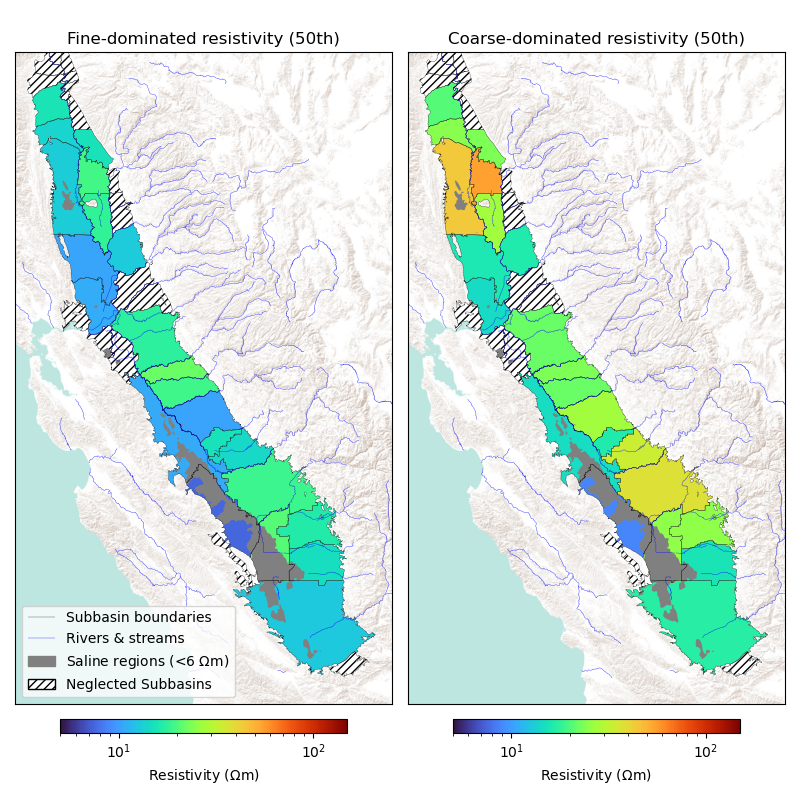

In [117]:
import matplotlib
matplotlib.rcParams['font.size'] = 10
legend_kwds = {'fraction':0.02, 'pad':0.02, 'orientation':'horizontal', 'label':'Resistivity ($\Omega$m)', 'norm':LogNorm(vmin=5, vmax=150)}

fig, axs = plt.subplots(1,2, figsize=(8, 8))
ax1, ax2 = axs
xlim = (-235738.88808281758, 146356.82349804082)
ylim = (-372488.7201856468, 287608.05395729607)
show(src, ax=ax1)
show(src, ax=ax2)
gdf_basins_3310_cv_active.plot(
    column='rho_fine_50th', cmap='turbo', ax=ax1, legend=True, legend_kwds=legend_kwds,
    norm=LogNorm(vmin=5, vmax=150),
    # vmin=10, vmax=21,
)
out = gdf_basins_3310_cv_active.plot(
    column='rho_coarse_50th', cmap='turbo', ax=ax2, legend=True, legend_kwds=legend_kwds,
    norm=LogNorm(vmin=5, vmax=150),    
    # vmin=14, vmax=43,
)

for ax in axs:
    gdf_basins_3310_cv.set_index('Basin_Su_1',inplace=False).loc[subbasin_names_inactive].plot(ax=ax, color='w', hatch='////')
    gdf_rho_salinity.plot(ax=ax, legend=True, color='grey')
    gdf_basins_3310_cv.boundary.plot(color='k', linewidth=0.2, ax=ax, label='Subbasin boundaries')
    gdf_rivers_3310.plot(color='b', linewidth=0.3, ax=ax, alpha=0.8, label='Rivers & streams')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("")
    ax.set_ylabel("")        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)  
    
x = [1, 2, 4, 3, 1]
y = [1, 3, 3, 1, 1]

# Plot the polygon

ax1.fill(x, y, color='grey', label='Saline regions (<6 $\Omega$m)')
ax1.fill_between((0,0), (1,1), color='w', hatch='////', label='Neglected Subbasins', edgecolors='k')  
ax1.legend(loc=3)
ax1.set_title("Fine-dominated resistivity (50th)")
ax2.set_title("Coarse-dominated resistivity (50th)")
plt.tight_layout()
plt.show()
fig.savefig("../figures/rho_cd_fd_cv.png", dpi=300)

In [118]:
gdf_basins_3310_cv_active

Basin_Name Basin_Subb  \
Basin_Su_1                                                                
SACRAMENTO VALLEY - BUTTE                  SACRAMENTO VALLEY   5-021.70   
SACRAMENTO VALLEY - COLUSA                 SACRAMENTO VALLEY   5-021.52   
SACRAMENTO VALLEY - CORNING                SACRAMENTO VALLEY   5-021.51   
SACRAMENTO VALLEY - SOLANO                 SACRAMENTO VALLEY   5-021.66   
SACRAMENTO VALLEY - NORTH AMERICAN         SACRAMENTO VALLEY   5-021.64   
SACRAMENTO VALLEY - SUTTER                 SACRAMENTO VALLEY   5-021.62   
SACRAMENTO VALLEY - RED BLUFF              SACRAMENTO VALLEY   5-021.50   
SACRAMENTO VALLEY - VINA                   SACRAMENTO VALLEY   5-021.57   
SACRAMENTO VALLEY - YOLO                   SACRAMENTO VALLEY   5-021.67   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  SAN JOAQUIN VALLEY   5-022.01   
SAN JOAQUIN VALLEY - KAWEAH               SAN JOAQUIN VALLEY   5-022.11   
SAN JOAQUIN VALLEY - WESTSIDE             SAN JOAQUIN VALLEY   5-022.09   
SAN JOAQUIN VALLEY - MODESTO              SAN JOAQUIN VALLEY   5-022.02   
SAN JOAQUIN VALLEY - TULARE LAKE          SAN JOAQUIN VALLEY   5-022.12   
SAN JOAQUIN VALLEY - KINGS                SAN JOAQUIN VALLEY   5-022.08   
SAN JOAQUIN VALLEY - CHOWCHILLA           SAN JOAQUIN VALLEY   5-022.05   
SAN JOAQUIN VALLEY - TURLOCK              SAN JOAQUIN VALLEY   5-022.03   
SAN JOAQUIN VALLEY - KERN COUNTY          SAN JOAQUIN VALLEY   5-022.14   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        SAN JOAQUIN VALLEY   5-022.07   
SAN JOAQUIN VALLEY - MERCED               SAN JOAQUIN VALLEY   5-022.04   
SAN JOAQUIN VALLEY - MADERA               SAN JOAQUIN VALLEY   5-022.06   
SAN JOAQUIN VALLEY - TULE                 SAN JOAQUIN VALLEY   5-022.13   

                                                                                   geometry  \
Basin_Su_1                                                                                    
SACRAMENTO VALLEY - BUTTE                 POLYGON ((-141696.413 168792.474, -141582.646 ...   
SACRAMENTO VALLEY - COLUSA                POLYGON ((-201099.430 198414.491, -201101.522 ...   
SACRAMENTO VALLEY - CORNING               POLYGON ((-178785.899 221125.977, -178819.685 ...   
SACRAMENTO VALLEY - SOLANO                POLYGON ((-163707.123 59610.571, -163715.429 5...   
SACRAMENTO VALLEY - NORTH AMERICAN        POLYGON ((-115741.598 114376.386, -115744.243 ...   
SACRAMENTO VALLEY - SUTTER                POLYGON ((-151889.846 144547.041, -153474.188 ...   
SACRAMENTO VALLEY - RED BLUFF             POLYGON ((-183037.412 256386.584, -183007.205 ...   
SACRAMENTO VALLEY - VINA                  POLYGON ((-174832.986 209448.925, -174832.976 ...   
SACRAMENTO VALLEY - YOLO                  POLYGON ((-190091.582 103204.233, -190077.609 ...   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  POLYGON ((-89815.421 32013.071, -89855.555 319...   
SAN JOAQUIN VALLEY - KAWEAH               MULTIPOLYGON (((45429.555 -179439.902, 45448.1...   
SAN JOAQUIN VALLEY - WESTSIDE             POLYGON ((-23380.493 -158694.385, -23530.863 -...   
SAN JOAQUIN VALLEY - MODESTO              POLYGON ((-40193.377 -38980.697, -40079.575 -3...   
SAN JOAQUIN VALLEY - TULARE LAKE          POLYGON ((42208.347 -172913.002, 42207.366 -17...   
SAN JOAQUIN VALLEY - KINGS                POLYGON ((26247.097 -117001.046, 26206.900 -11...   
SAN JOAQUIN VALLEY - CHOWCHILLA           POLYGON ((-30775.001 -92300.000, -32367.248 -9...   
SAN JOAQUIN VALLEY - TURLOCK              POLYGON ((-40199.880 -38975.472, -40206.288 -3...   
SAN JOAQUIN VALLEY - KERN COUNTY          POLYGON ((96298.618 -246860.668, 96291.161 -24...   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        POLYGON ((-122322.254 -37925.856, -122310.776 ...   
SAN JOAQUIN VALLEY - MERCED               MULTIPOLYGON (((-5486.395 -93019.690, -5457.13...   
SAN JOAQUIN VALLEY - MADERA               POLYGON ((-4537.847 -92544.938, -4562.016 -925...   
SAN JOAQUIN VALLEY - TULE                 POLYGON ((73032.797 -2

In [119]:
(gdf_basins_3310_cv_active['rho_coarse_50th'] / gdf_basins_3310_cv_active['rho_fine_50th']).mean()

1.620298933600035

In [120]:
gdf_basins_3310_cv_active.mean()

area_square_km         2050.333626
counts                 1183.772727
sed_density               0.657080
aem_counts            12995.545455
sed_counts             1183.772727
wt_counts               106.636364
aem_density               7.120571
wt_density                0.059755
num_coloc_max           376.454545
opt_coloc_distance      385.000000
rho_fine_50th            14.970541
rho_coarse_50th          24.055799
ncolocs                 187.818182
dtype: float64

In [121]:
gdf_basins_3310_cv_active.max()

Basin_Name            SAN JOAQUIN VALLEY
Basin_Subb                      5-022.14
area_square_km                7212.79315
counts                              4573
sed_density                     1.702555
aem_counts                         30443
sed_counts                          4573
wt_counts                            294
aem_density                    13.914251
wt_density                      0.161733
num_coloc_max                     1259.0
opt_coloc_distance                 600.0
rho_fine_50th                  22.100405
rho_coarse_50th                54.749355
ncolocs                              462
dtype: object

In [122]:
gdf_basins_3310_cv_active

Basin_Name Basin_Subb  \
Basin_Su_1                                                                
SACRAMENTO VALLEY - BUTTE                  SACRAMENTO VALLEY   5-021.70   
SACRAMENTO VALLEY - COLUSA                 SACRAMENTO VALLEY   5-021.52   
SACRAMENTO VALLEY - CORNING                SACRAMENTO VALLEY   5-021.51   
SACRAMENTO VALLEY - SOLANO                 SACRAMENTO VALLEY   5-021.66   
SACRAMENTO VALLEY - NORTH AMERICAN         SACRAMENTO VALLEY   5-021.64   
SACRAMENTO VALLEY - SUTTER                 SACRAMENTO VALLEY   5-021.62   
SACRAMENTO VALLEY - RED BLUFF              SACRAMENTO VALLEY   5-021.50   
SACRAMENTO VALLEY - VINA                   SACRAMENTO VALLEY   5-021.57   
SACRAMENTO VALLEY - YOLO                   SACRAMENTO VALLEY   5-021.67   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  SAN JOAQUIN VALLEY   5-022.01   
SAN JOAQUIN VALLEY - KAWEAH               SAN JOAQUIN VALLEY   5-022.11   
SAN JOAQUIN VALLEY - WESTSIDE             SAN JOAQUIN VALLEY   5-022.09   
SAN JOAQUIN VALLEY - MODESTO              SAN JOAQUIN VALLEY   5-022.02   
SAN JOAQUIN VALLEY - TULARE LAKE          SAN JOAQUIN VALLEY   5-022.12   
SAN JOAQUIN VALLEY - KINGS                SAN JOAQUIN VALLEY   5-022.08   
SAN JOAQUIN VALLEY - CHOWCHILLA           SAN JOAQUIN VALLEY   5-022.05   
SAN JOAQUIN VALLEY - TURLOCK              SAN JOAQUIN VALLEY   5-022.03   
SAN JOAQUIN VALLEY - KERN COUNTY          SAN JOAQUIN VALLEY   5-022.14   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        SAN JOAQUIN VALLEY   5-022.07   
SAN JOAQUIN VALLEY - MERCED               SAN JOAQUIN VALLEY   5-022.04   
SAN JOAQUIN VALLEY - MADERA               SAN JOAQUIN VALLEY   5-022.06   
SAN JOAQUIN VALLEY - TULE                 SAN JOAQUIN VALLEY   5-022.13   

                                                                                   geometry  \
Basin_Su_1                                                                                    
SACRAMENTO VALLEY - BUTTE                 POLYGON ((-141696.413 168792.474, -141582.646 ...   
SACRAMENTO VALLEY - COLUSA                POLYGON ((-201099.430 198414.491, -201101.522 ...   
SACRAMENTO VALLEY - CORNING               POLYGON ((-178785.899 221125.977, -178819.685 ...   
SACRAMENTO VALLEY - SOLANO                POLYGON ((-163707.123 59610.571, -163715.429 5...   
SACRAMENTO VALLEY - NORTH AMERICAN        POLYGON ((-115741.598 114376.386, -115744.243 ...   
SACRAMENTO VALLEY - SUTTER                POLYGON ((-151889.846 144547.041, -153474.188 ...   
SACRAMENTO VALLEY - RED BLUFF             POLYGON ((-183037.412 256386.584, -183007.205 ...   
SACRAMENTO VALLEY - VINA                  POLYGON ((-174832.986 209448.925, -174832.976 ...   
SACRAMENTO VALLEY - YOLO                  POLYGON ((-190091.582 103204.233, -190077.609 ...   
SAN JOAQUIN VALLEY - EASTERN SAN JOAQUIN  POLYGON ((-89815.421 32013.071, -89855.555 319...   
SAN JOAQUIN VALLEY - KAWEAH               MULTIPOLYGON (((45429.555 -179439.902, 45448.1...   
SAN JOAQUIN VALLEY - WESTSIDE             POLYGON ((-23380.493 -158694.385, -23530.863 -...   
SAN JOAQUIN VALLEY - MODESTO              POLYGON ((-40193.377 -38980.697, -40079.575 -3...   
SAN JOAQUIN VALLEY - TULARE LAKE          POLYGON ((42208.347 -172913.002, 42207.366 -17...   
SAN JOAQUIN VALLEY - KINGS                POLYGON ((26247.097 -117001.046, 26206.900 -11...   
SAN JOAQUIN VALLEY - CHOWCHILLA           POLYGON ((-30775.001 -92300.000, -32367.248 -9...   
SAN JOAQUIN VALLEY - TURLOCK              POLYGON ((-40199.880 -38975.472, -40206.288 -3...   
SAN JOAQUIN VALLEY - KERN COUNTY          POLYGON ((96298.618 -246860.668, 96291.161 -24...   
SAN JOAQUIN VALLEY - DELTA-MENDOTA        POLYGON ((-122322.254 -37925.856, -122310.776 ...   
SAN JOAQUIN VALLEY - MERCED               MULTIPOLYGON (((-5486.395 -93019.690, -5457.13...   
SAN JOAQUIN VALLEY - MADERA               POLYGON ((-4537.847 -92544.938, -4562.016 -925...   
SAN JOAQUIN VALLEY - TULE                 POLYGON ((73032.797 -2

In [123]:
# fig = plt.figure()
# plt.plot(ncoloc_matrix.max(axis=1), 'o')
# plt.show()


In [124]:
gdf_basins_3310_cv_active.to_file("subbasins_cv_rockphysics.geojson")

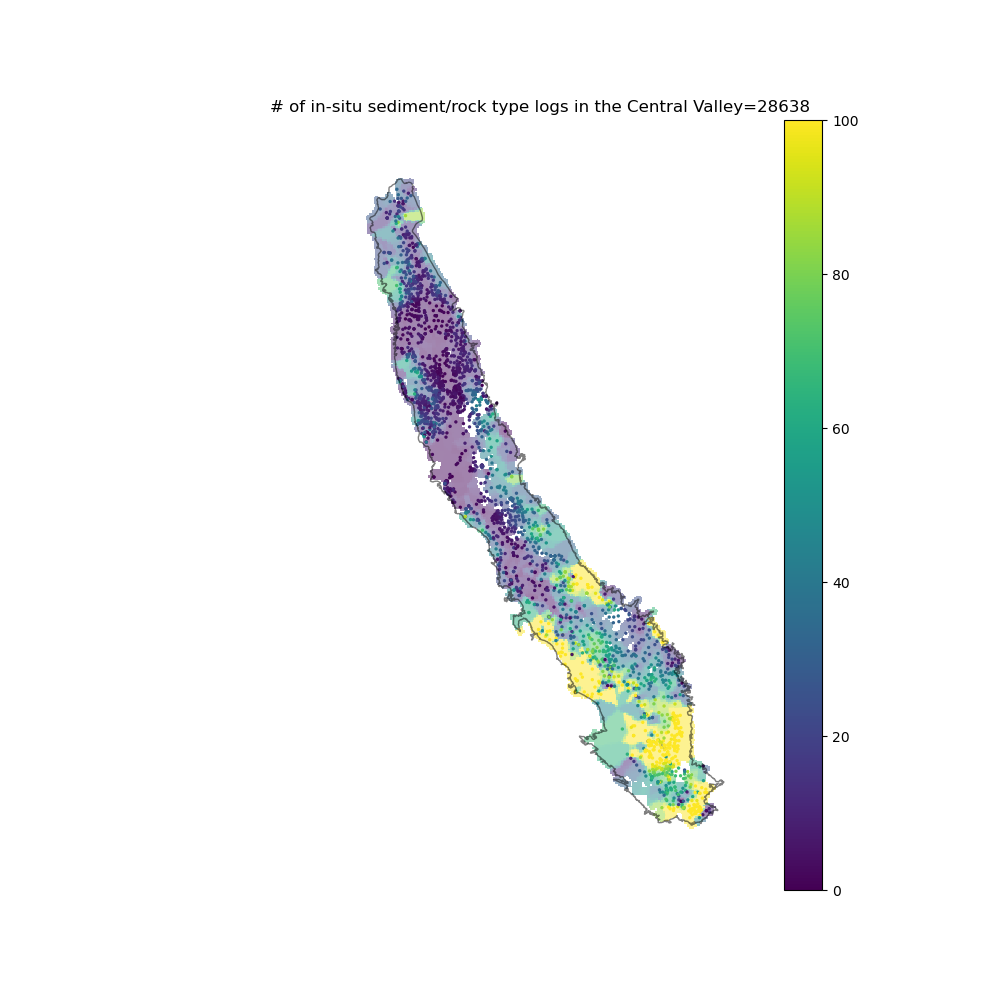

In [125]:
x_wt = df_waterlevel_survey['UTMX'].values
y_wt = df_waterlevel_survey['UTMY'].values
xy_wt = np.c_[x_wt, y_wt]
gse_wse = df_waterlevel_survey['GSE_WSE'].values

fig, ax = plt.subplots(1,1, figsize=(10, 10))
# gdf_plss_3310.boundary.plot(ax=ax)
gdf_cv_3310.boundary.plot(ax=ax, color='k', linewidth=1, alpha=0.5)
ax.pcolormesh(water_table['x'], water_table['y'], water_table['wse_idw'], vmin=0, vmax=100, alpha=0.5)
out = ax.scatter(
    df_waterlevel_survey['UTMX'], df_waterlevel_survey['UTMY'], c=df_waterlevel_survey['GSE_WSE'],
    s=2, vmin=0, vmax=100
)

plt.colorbar(out, ax=ax)
ax.set_title(f"# of in-situ sediment/rock type logs in the Central Valley={n_sed}")
plt.axis('off')
plt.show()

In [126]:
# # interpolation for water table
# import numpy as np
# from matplotlib import pyplot as plt
# from pykrige.ok import OrdinaryKriging
# import gstools as gs

# # xmin = gdf_basin_tmp.bounds['minx'].values[0]
# # xmax = gdf_basin_tmp.bounds['maxx'].values[0]
# # ymin = gdf_basin_tmp.bounds['miny'].values[0]
# # ymax = gdf_basin_tmp.bounds['maxy'].values[0]
# # grid definition for output field
# # gridx = np.arange(xmin, xmax, dx)
# # gridy = np.arange(ymin, ymax, dy)
# gridx = water_table['x']
# gridy = water_table['y']
# model = gs.Gaussian(
#     dim=2, len_scale=10000, var=1, nugget=0.1
# )

# OK1 = OrdinaryKriging(xy_wt[:,0], xy_wt[:,1], gse_wse, variogram_model=model)
# z1, ss1 = OK1.execute("grid", gridx, gridy)

In [127]:
# fig, ax = plt.subplots(1,1)
# out = ax.pcolormesh(gridx, gridy, z1, vmin=gse_wse.min(), vmax=100)
# # ax.scatter(xy_wt_tmp[:,0], xy_wt_tmp[:,1], c=gse_wse, vmin=gse_wse.min(), vmax=gse_wse.max(), s=10, edgecolor='k')
# ax.set_aspect(1)
# plt.colorbar(out, fraction=0.02)
# plt.tight_layout()
# plt.show()